In [1]:
import os
import numpy as np
import cv2
import pandas as pd
from skimage import measure

def extract_signal_from_image(lead_binary, calibration_pixel):
    height, width = lead_binary.shape
    signal = np.full(width, np.nan)

    for col in range(width):
        rows_with_signal = np.where(lead_binary[:, col] == 1)[0]
        if rows_with_signal.size > 0:
            middle_row = int(np.round(np.mean(rows_with_signal)))
            signal[col] = middle_row

    # Normalize: Convert pixel distance to mV
    signal = -(signal - calibration_pixel) * (0.1 / 7.87)  # 0.1 mV per mm, 7.87 px per mm
    return signal

def process_images(input_folder, output_file, calibration_pixel, sampling_rate=100, total_time=2.5):
    num_samples = int(total_time * sampling_rate) #250
    time_axis = np.linspace(0, total_time, num_samples) #0.01 seconds or 10milliseconds

    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith('.png')]
    all_signals = np.zeros((num_samples, len(image_files)))

    for idx, file_name in enumerate(image_files):
        image_path = os.path.join(input_folder, file_name)
        image = cv2.imread(image_path)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        value_channel = hsv_image[:, :, 2]
        
        _, binary_image = cv2.threshold(value_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        binary_image = (binary_image == 0).astype(np.uint8)  # Invert binary: signal as 1

        # Filter connected components by area
        labeled_image = measure.label(binary_image, connectivity=2)
        props = measure.regionprops(labeled_image)
        
        size_threshold = 900
        filtered_image = np.zeros_like(binary_image)
        for prop in props:
            if prop.area >= size_threshold:
                coords = prop.coords
                filtered_image[coords[:, 0], coords[:, 1]] = 1

        signal = extract_signal_from_image(filtered_image, calibration_pixel)

        if np.all(np.isnan(signal)):
            print(f"Warning: Signal extraction failed for {file_name}")
            continue

        # Interpolate to match desired sample count
        valid_idx = ~np.isnan(signal)
        if np.sum(valid_idx) < 2:
            print(f"Warning: Not enough valid points in {file_name}")
            continue

        x_original = np.linspace(0, total_time, signal.size)
        signal_interp = np.interp(time_axis, x_original[valid_idx], signal[valid_idx])

        # Convert to microvolt
        signal_microvolt = signal_interp * 1000

        all_signals[:, idx] = signal_microvolt

    # Save to CSV
    df = pd.DataFrame(all_signals)
    df.to_csv(output_file, index=False)
    print("Signal extraction and saving completed.")

# Example usage
input_folder = "C:\\Users\\SOMEN\\Downloads\\DLH-Day2\\summer internship-25\\00001_lr-0\\I.png"
output_file = "output\\I_signals.csv"
calibration_pixel = 189  # Example calibration pixel (adjust as needed)

process_images(input_folder, output_file, calibration_pixel)


NotADirectoryError: [WinError 267] The directory name is invalid: 'C:\\Users\\SOMEN\\Downloads\\DLH-Day2\\summer internship-25\\00001_lr-0\\I.png'

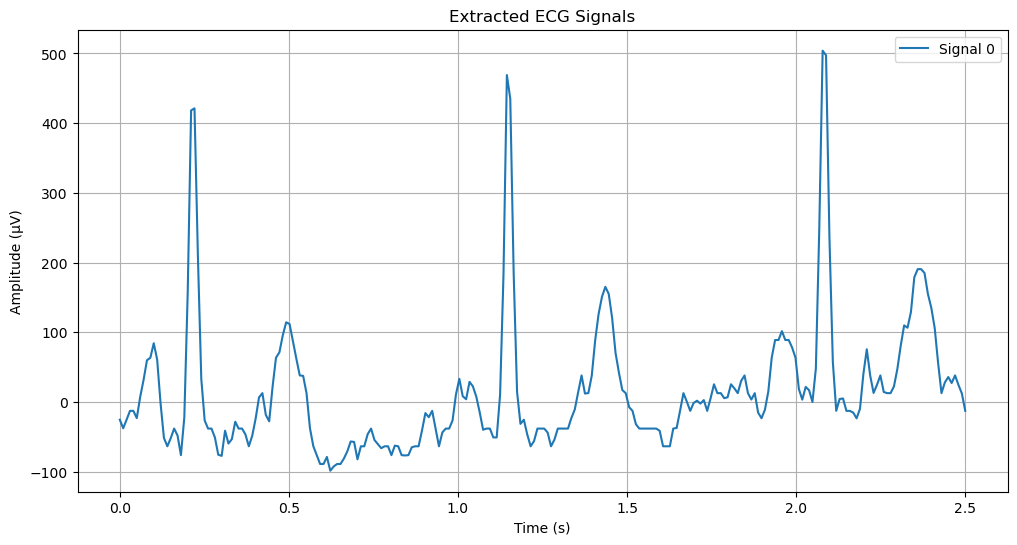

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Replace with your CSV file path
csv_file = r"E:\Theory section\IMp PPT\summer internship-25\00001_lr-0\I_signals.csv"

# Sampling info
sampling_rate = 100  # Hz
total_time = 2.5  # seconds
num_samples = int(total_time * sampling_rate)
time_axis = np.linspace(0, total_time, num_samples)

# Load CSV
df = pd.read_csv(csv_file)

# Plot each signal column
plt.figure(figsize=(12, 6))
for col in df.columns:
    plt.plot(time_axis, df[col], label=f'Signal {col}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title('Extracted ECG Signals')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# %for 254 DPI images
# %calibration_pixel = 241; % For Lead I,AVR,V1,V4
# %calibration_pixel = 251; % For Lead II,AVL,V2,V5
# %calibration_pixel = 261; % For Lead III,AVF,V3,V6

# %for 200 DPI images
# %calibration_pixel = 189; % For Lead I,AVR,V1,V4
# %calibration_pixel = 197; % For Lead II,AVL,V2,V5
# calibration_pixel = 205; % For Lead III,AVF,V3,V6
